In [80]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
from mne.datasets.limo import load_data

import seaborn as sns
import matplotlib
import matplotlib.pylab as pl
import sys
sys.path.insert(0,"..")
from ccs_eeg_utils import spline_matrix


# choose any subject 1 - 18
limo_epochs = load_data(subject=3,path='../local/limo') #


Adding metadata with 2 columns
Replacing existing metadata with 2 columns
1072 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


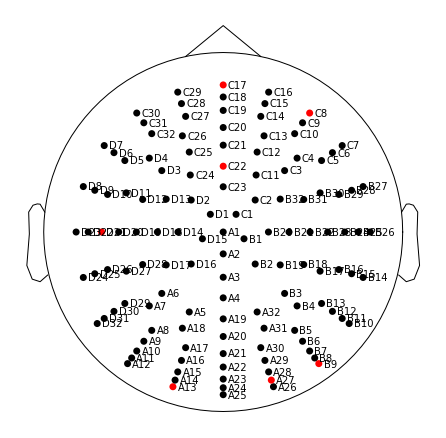

In [81]:
limo_epochs.plot_sensors(show_names=True);

- Extract data from electrode `B11`, this will be your 'y'

In [82]:
y = limo_epochs.get_data(picks="B11")

In [83]:
y.shape

(1072, 1, 201)

- The linear covariate is saved in a dataframe called limo_epochs.metadata. Metadata is yet another way that you can save event-related information besides annotations & events
- Generate a (design) matrix consisting of an intercet and a linear predictor of phase-coherence.


In [84]:

X = np.ones([limo_epochs._data.shape[0],2])
phase_coh = limo_epochs.metadata['phase-coherence']

X[:,0] = 1
X[:,1] =phase_coh


In [85]:
print(X.shape)
y.shape

(1072, 2)


(1072, 1, 201)

- Use `scipy.linalg.lstsq` or similar functions to solve the LeastSquares Problem at each time-point of the epoch

In [86]:
b,res,rnk,s = scipy.linalg.lstsq(X, y[:,0,:])

In [87]:
b.shape

(2, 201)

- Plot the result parameters and comment what the two parameters represent.

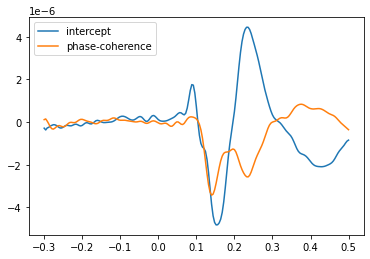

In [88]:
plt.plot(limo_epochs.times,b.T)
plt.legend(["intercept","phase-coherence"])

- Evaluate continuous regressor at the unique 18 coherence (noise) levels that were used in the experiment and plot them (hint: you could use $X_{new}b$ but dont have to in this simple example)
- Should you add the Intercept to the resulting Plot?

## Compare it to binned data
- Next, generate one evoked.average() for each of the 18 stimulus coherence values.
- Plot them and compare them to your predictions. How well does a continuous predictor capture the data?

In [89]:
#(partially taken from MNE tutorial: https://mne.tools/dev/auto_examples/datasets/plot_limo_data.html)
# get levels of phase coherence
levels = sorted(phase_coh.unique())
# create labels for levels of phase coherence (i.e., 0 - 85%)
labels = ["{0:.2f}".format(i) for i in np.arange(0., 0.90, 0.05)]

# create dict of evokeds for each level of phase-coherence
evokeds = {label: limo_epochs[phase_coh == level].average()
           for level, label in zip(levels, labels)}


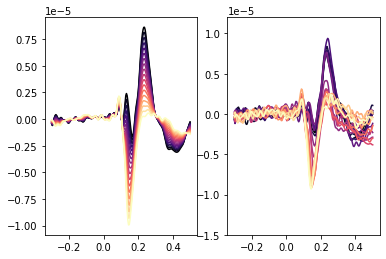

In [90]:
# how many levels to evaluate
n = 18
# get unique phase-corr levels
phase_corr_levels = np.sort(limo_epochs.metadata['phase-coherence'].unique())

# build a designmatrix 
# we could put np.ones(n)*0 to remove the intercept
Xnew = np.vstack((np.ones(n),phase_corr_levels)).T

colors = plt.cm.magma(np.linspace(0,1,n))

# This is the important bit!
y_pred = Xnew@b

fig,(ax1,ax2) = plt.subplots(1,2)
# plot the predicted ERPs
for i in range(n):
    ax1.plot(limo_epochs.times,y_pred[i,:] , color=colors[i])
    plt.ylim(np.array([-1.5,1.2])*10**-5)

# Plot the ERPs for each evoked object

for i,(k,v) in enumerate(evokeds.items()):
    d = v.pick(['B11']).data # nt really sure why this is a function?!
    ax2.plot(limo_epochs.times,d.T , color=colors[i],label=i)
    plt.ylim(np.array([-1.5,1.2])*10**-5)


## Converting a continuous predictor to a spline predictor
- For this exercise we need `from ccs_eeg_utils import spline_matrix` function.
- The function requires to specify where the spline bases should be evaluated `x` (the coherence value of each epoch) and where the `knots` should be. Think of the knots as the anchorpoints of the spline set. (*Note*: There is a huge literature on knot placement etc. we just use a linspace over the range of our continuous variable. If you want you can play around and e.g. place more knots in the middle than the end). How many knots you ask? Choose a reasonable low number, you can change it later again. There are ways to decide this but they are outside the tutorial. Stay below 10.

- Plot the basisfunction as line-plots
- Plot the designmatrix as an 2D image


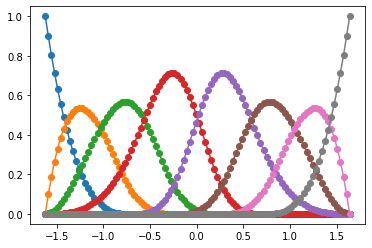

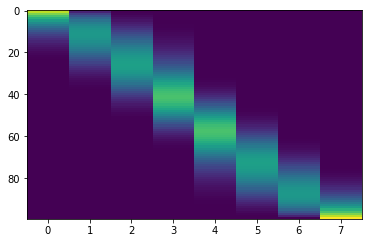

In [91]:

fr = phase_corr_levels[0]
to = phase_corr_levels[len(phase_corr_levels)-1]

knotseq = np.linspace(fr,to,num=8) #np.linspace(0,0.90,num=8)

# from where to where to evaluate the splines?
# min-corr : max-corr
x = np.linspace(fr,to,num=100)

# run the ccs-provided function to generate splines
Xbs = spline_matrix(x,knots =knotseq)
plt.plot(x,Xbs,'o-')
plt.show()
plt.imshow(Xbs,aspect=1./20,interpolation='none')

- Fit the splines to your data (*Note*: If you wonder about the intercept, there are two ways here.Take the whole spline matrix and dont add an intercept {the intercept is implicit in the spline matrix}, or remove one spline and add an intercept {now all spline-predictors are relativ to the intercept}. Note that due to potential asymmetries in the spline basis set, the intercept is not necessarily what you would expect, see below)

In [92]:
X_spl = spline_matrix(limo_epochs.metadata['phase-coherence'],knots =knotseq)
b_spl,res,rnk,s = scipy.linalg.lstsq(X_spl, y[:,0,:])

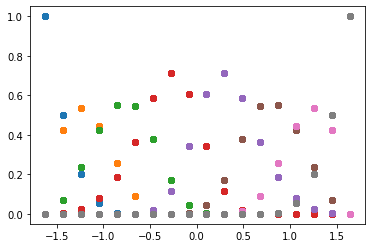

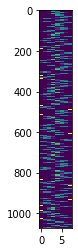

In [93]:
plt.plot(limo_epochs.metadata['phase-coherence'],X_spl,'o')
plt.show()
plt.imshow(X_spl,aspect=1./20,interpolation='none')

- Plot the resulting "raw" coefficients

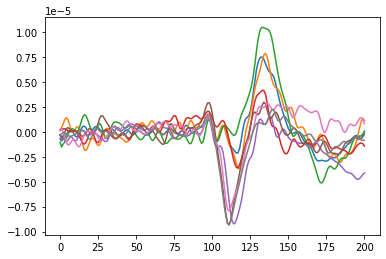

In [94]:
plt.plot(b_spl.T);

- The "raw" coefficients are hard to interpret. We should run conditional values again. Evaluate the fitted spline-betas at the respective 18 coherence levels and plot them.

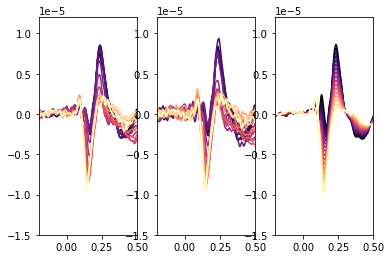

In [96]:
# get the designmatrix for only few corr-values
Xnew = spline_matrix(np.linspace(fr, to, num=18),knotseq)

# get colors as well
colors = plt.cm.magma(np.linspace(0,1,18))

# this is the "magic"
y_pred_bs = Xnew@b_spl


# Similar plot to before
ax = plt.subplots(1,3)[1]
# plot the spline ERPs
for i in range(n):
    ax[0].plot(limo_epochs.times,y_pred_bs[i,:] , color=colors[i])

# plot the binned one
for i,(k,v) in enumerate(evokeds.items()):
    d = v.pick(['B11']).data # nt really sure why this is a function?!
    ax[1].plot(limo_epochs.times,d.T , color=colors[i])

# plot the linear ERPs
for i in range(n):
    ax[2].plot(limo_epochs.times,y_pred[i,:] , color=colors[i])

plt.setp(ax,xlim=[-0.2,0.5],ylim=(np.array([-1.5,1.2])*10**-5));


- We will add a categorical regressor to our spline designmatrix: The difference of FaceA vs. FaceB. Note: If you havent remove a spline-column yet, please do so now and include an intercept.
- Because it is a categorical predictor, we have to encode it using either dummy coding (e.g. FaceA = 0, FaceB = 1) or effect coding (FaceA = -0.5, FaceB = 0.5 {you could also use -1 / 1})
- Fit the model, and plot the faceA/faceB effect


In [111]:
# Coh-Spline
X_spl = spline_matrix(phase_coh,knots =knotseq)
# intercept
intercept = np.ones(X_spl.shape[0])
# face-effect
faceB = (limo_epochs.metadata.face.values == "B")*2-1 # effect coded

# get all of those
X = np.vstack((intercept,faceB,X_spl[:,:-1].T))

# fit it
b,res,rnk,s = scipy.linalg.lstsq(X.T, y[:,0,:])


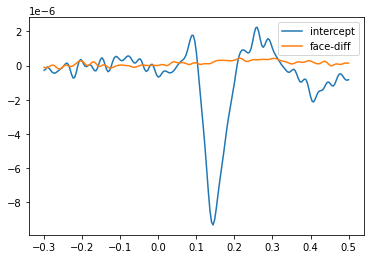

In [117]:
# face-effect is the second beta

plt.plot(limo_epochs.times,b[0:2,:].T)
plt.legend(["intercept","face-diff"])

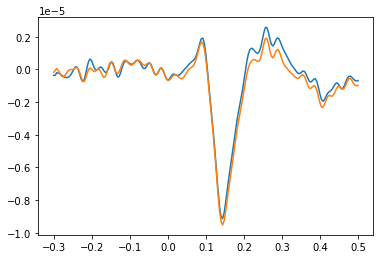

In [118]:
plt.plot(limo_epochs.times,b.T@np.matrix([[1, 1,0,0,0,0,0,0,0],
                                          [1,-1,0,0,0,0,0,0,0]] ).T)

- In order to facilitate calculating such effects, often a contrast-vector (or matrix) is used. We have a vector $b$ that in our case represents $[b_{intercept},b_{faceB},b_{spline1}, \dots, b_{splineN}]$. We typically want to use a sum of predictors, ie. $b_{intercept}$ + $b_{faceB}$ which can be represented as a matrix multiplication of $b*c$ with $c = [1,1,0,\dots,0]$. If we chose effect coding before, we would need to put in the effect coded coefficients in our contrast-vector. I.e. $c = [1,-0.5,0,\dots,0]$ or $c = [1,-1,0,\dots,0]$. And finally, we could also combine multiple contrast vectors to one matrix to evaluate multiple effects of interest.



- Use a contrast matrix to plot the FaceA and FaceB ERP. Note that in difference to the example contrats-vector above, we now also want to add the correct spline-values. For this evaluate the spline-coefficients at noise-coherence of 0.9 and replace the 0's of your $c_{spline1} \dots c_{splineN}$ contrast vector.

In [125]:
knotseq

array([-1.6209372 , -1.15515417, -0.68937115, -0.22358812,  0.24219491,
        0.70797793,  1.17376096,  1.63954398])

In [132]:
#  the calculation above slightly wrong, because I am putting all splines simply to 0. Because I removed the last spline, the implicit intercept relates to the lowest noiselevel. But due to the overlap of the spline-basis functions,  some spline-basis-betas should be non-zero. But which? Let's find out
print(spline_matrix([0],knots =knotseq))

[[0.         0.         0.01757333 0.49740426 0.47119613 0.01382628
  0.         0.        ]]


In [124]:
print(spline_matrix([1.6],knots =knotseq))

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.54964056e-05 3.49333873e-03 1.18498707e-01 8.77982458e-01]]


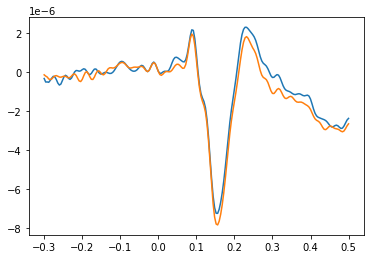

In [135]:
# I am making it explicit here which numbers I choose instead of concatenating
plt.plot(limo_epochs.times,b.T@np.matrix([[1, 1, 0,0,0, 0.16677456, 0.53777498,  0.28669231, 0.00875815],
                                          [1,-1,0,0,0, 0.16677456, 0.53777498,  0.28669231, 0.00875815]] ).T)

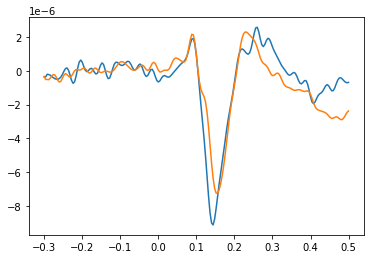

In [136]:
# How much difference did it make? 
plt.plot(limo_epochs.times,b.T@np.matrix([[1,1, 0,0,0,0,0,0,0]] ).T)
plt.plot(limo_epochs.times,b.T@np.matrix([[1,1, 0,0,0, 0.16677456, 0.53777498,  0.28669231, 0.00875815]] ).T)

## Bonus:
- There could be an interaction between the spline set and the categorical variable. For this, we have to calculate all pairwise multiplications of the faceB-column, with the spline columns.
- Fit the resulting model and check whether you found an interaction effect

In [140]:
X = np.vstack((intercept,faceB,X_spl[:,:-1].T))  # generate designmatrix 
X_interact = (X[1,:].reshape(X.shape[1],1) * X[2:,:].T).T # generate interaction matrix

b_interact,res,rnk,s = scipy.linalg.lstsq(np.vstack((X,X_interact)).T, y[:,0,:]) # fit both combined


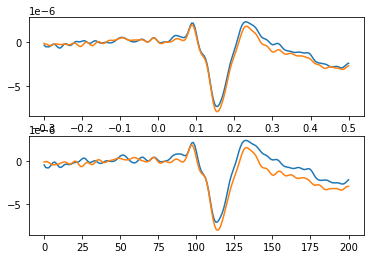

In [141]:
plt.subplot(2,1,1).plot(limo_epochs.times,b.T@np.matrix([[1,1, 0,0,0, 0.16677456, 0.53777498,  0.28669231, 0.00875815],
                                                         [1,-1,0,0,0, 0.16677456, 0.53777498,  0.28669231, 0.00875815]] ).T)
plt.subplot(2,1,2).plot(b_interact.T@np.matrix([
    [1,1, 0,0,0, 0.16677456, 0.53777498,  0.28669231, 0.00875815, 0,0,0,  0.16677456,  0.53777498,   0.28669231,  0.00875815],
    [1,-1,0,0,0, 0.16677456, 0.53777498,  0.28669231, 0.00875815, 0,0,0, -0.16677456, -0.53777498,  -0.28669231, -0.00875815]] ).T) # note how we multiplied the second term with -1, identical to the c_FaceB term in the beginning of each contrast


    # Also note: We are not doing any statistics here!

## Fitting a model in MNE
Typically, one wouldnt fit the models with scipy manually, but one can use MNE to handle the fits (or even dedicated toolboxes like unfold* - but I am not aware of a documented toolbox in python). This also gives you much more support, i.e. gives you standard errors(=SE),and through t = effect/SE, the t-values which can be easily looked up in the analytical H0 distribution and converted to single subject p-values.

- import `from mne.stats import linear_regression`
- Fit a model `y~1 + faceB + coherence`, thus a model with linear coherence effect: mne also requires to specify your own designmatrix, you can also give the columns names using `res = linear_regression(...,names=['Intercept','effectB' ...])`.


In [142]:
predictor_vars = ['face B - face A', 'phase-coherence', 'intercept']

# create design matrix data-frame
design = limo_epochs.metadata[['phase-coherence', 'face']].copy()
design['intercept'] = 1
design['face B - face A'] = (limo_epochs.metadata['face'] == 'B')*2-1

design = design[predictor_vars]

from mne.stats import linear_regression
reg = linear_regression(limo_epochs,
                        design_matrix=design,
                        names=predictor_vars)

design

Fitting linear model to epochs, (26532 targets, 3 regressors)


/tmp/ipykernel_317829/2779453045.py:11: RuntimeWarning: Fitting linear model to non-data or bad channels. Check picking
  reg = linear_regression(limo_epochs,


Done


,face B - face A,phase-coherence,intercept
0,-1,1.255958,1
1,-1,0.296993,1
2,-1,-0.086593,1
3,-1,-1.429144,1
4,-1,-0.853765,1
...,...,...,...
1067,1,-0.086593,1
1068,1,0.105200,1
1069,1,-0.853765,1
1070,1,-0.470179,1


- You can access the terms using res['Intercept'], and plot e.g. the betas using `res['Intecept'].beta.plot()`

In [144]:
reg['intercept']

lm(beta=<Evoked | '' (average, N=1), -0.29994 – 0.49991 sec, baseline off, 132 ch, ~381 kB>, stderr=<Evoked | '' (average, N=1), -0.29994 – 0.49991 sec, baseline off, 132 ch, ~381 kB>, t_val=<Evoked | '' (average, N=1), -0.29994 – 0.49991 sec, baseline off, 132 ch, ~381 kB>, p_val=<Evoked | '' (average, N=1), -0.29994 – 0.49991 sec, baseline off, 132 ch, ~381 kB>, mlog10_p_val=<Evoked | '' (average, N=1), -0.29994 – 0.49991 sec, baseline off, 132 ch, ~381 kB>)

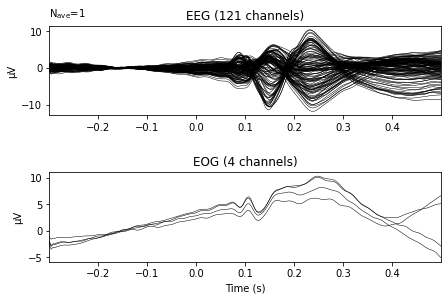

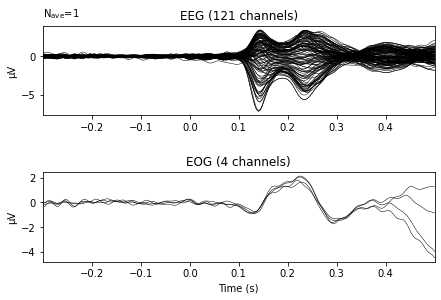

In [149]:
reg['intercept'].beta.plot();
reg['phase-coherence'].beta.plot();

- Because we have all channels now, we can also plot topoplots. Think about how you could visualize the splines as topoplots (note: this is a hard question)

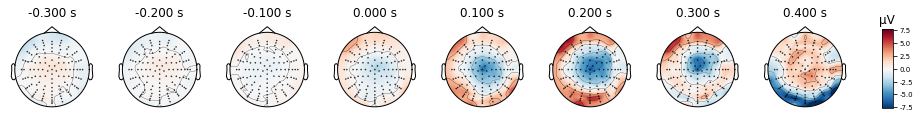

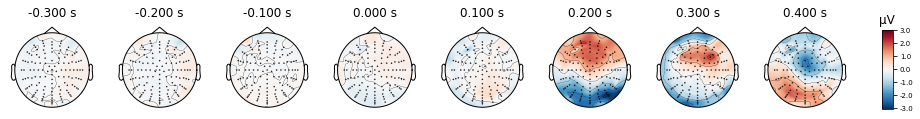

In [150]:
reg['intercept'].beta.plot_topomap(times = np.arange(-0.3,0.5,0.1))
reg['phase-coherence'].beta.plot_topomap(times = np.arange(-0.3,0.5,0.1));

- You can also plot the p-values using res['phase_coherence'].p_val.plot(). Do they follow your intuition? 

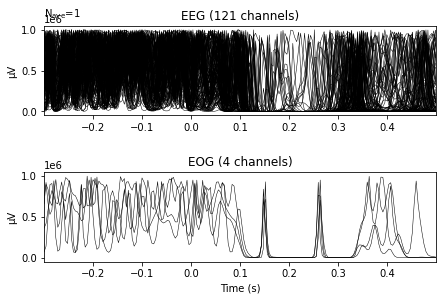

In [151]:
reg['phase-coherence'].p_val.plot();

- **Bonus:** What does the distribution (histogram) of p-values of phase-coherence look like during the baseline? (note, bad channels are not automatically removed in MNE, thus you might want to increase your bin-width to spot them


In [153]:
pH0 = reg['phase-coherence'].p_val.copy().crop(tmax=0);

In [156]:
pH0.data.shape

(132, 76)

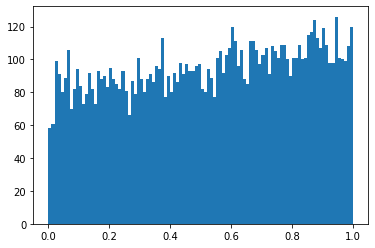

In [158]:
plData = pH0.data[np.where(np.sum(pH0.data > 0.99,axis=1) < 25),:]
plt.hist(plData.reshape(np.prod(plData.shape)),bins=100);

In [161]:
np.mean(plData.reshape(np.prod(plData.shape)) < 0.05)

0.040736842105263155

In [155]:
# the channels with the many 1's are the bad channels
np.where(np.sum(pH0.data > 0.99,axis=1) > 25)

(array([ 12,  26,  40,  71,  80,  85, 116]),)